## WorldMove Data EDA

### a. Overview

WorldMove is a large-scale synthetic mobility dataset covering over 1,600 cities across 179 countries and 6 continents. The dataset uses a diffusion-based generative model to create realistic urban mobility patterns from publicly available data sources.

Links

- **Official Website**: [WorldMove Dataset Portal](https://www.fiblab.net/worldmove/)
- **GitHub Repository**: [https://github.com/tsinghua-fib-lab/WorldMove](https://github.com/tsinghua-fib-lab/WorldMove)
- **Research Paper**: [arXiv:2504.10506](https://arxiv.org/abs/2504.10506)


### b. libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import json
import matplotlib.pyplot as plt

### c. load grid coordinates

In [2]:
# load grid coordinates from JSON file
coord_file = '/home/dataopske/Desktop/jav/data/raw/worldmove/gridcell_coordinates.json'

with open(coord_file, 'r') as f:
    coordinates = json.load(f)

In [3]:
# convert to DataFrame
coord_df = pd.DataFrame([
    {'cell_id': int(k), 'lon': v[0], 'lat': v[1]}
    for k, v in coordinates.items()
])

- centers of 1km x 1km grid cells covering Nairobi (1,440 cells total) 

In [4]:
coord_df

cell_id        lon       lat
0           0  36.668782 -1.165734
1           1  36.675437 -1.167976
2           2  36.689270 -1.165173
3           3  36.697704 -1.167777
4           4  36.709964 -1.161586
...       ...        ...       ...
1435     1435  37.057568 -1.428876
1436     1436  37.062095 -1.428653
1437     1437  37.073072 -1.422124
1438     1438  37.083236 -1.423418
1439     1439  37.085200 -1.422310

[1440 rows x 3 columns]

In [5]:
print(f"Loaded {len(coord_df)} grid cells")
print(f"\nCoordinate ranges:")
print(f"  Longitude: [{coord_df['lon'].min():.4f}, {coord_df['lon'].max():.4f}]")
print(f"  Latitude:  [{coord_df['lat'].min():.4f}, {coord_df['lat'].max():.4f}]")

Loaded 1440 grid cells

Coordinate ranges:
  Longitude: [36.6662, 37.0933]
  Latitude:  [-1.4295, -1.1614]


#### d. load population data

In [6]:
# load population data
pop_file = '/home/dataopske/Desktop/jav/data/raw/worldmove/grid-cell_population.npy'

population = np.load(pop_file)

# population summary
print(f"  Population grid shape: {population.shape}")
print(f"  Total population: {population.sum():,.0f}")
print(f"  Max per cell: {population.min():,.0f}")
print(f"  Max per cell: {population.max():,.0f}")
print(f"  Mean per cell: {population.mean():.0f}")

  Population grid shape: (30, 48)
  Total population: 20,754,780
  Max per cell: 23
  Max per cell: 280,940
  Mean per cell: 14413


- since WorldMove generates synthetic trajectories, the 20M might represent the number of simulated agents they generated for realistic mobility patterns, not actual people. the model might intentionally oversample to ensure statistical coverage of all mobility patterns.

- since the data covers the Nairobi Metropolitan area. I will normalise the data to approx 5.7M as per the latest KNBS estimate

This notebook cell processes a gridded population dataset (e.g., from WorldPop) to calibrate estimates specifically for the Nairobi metropolitan area. It uses a point-in-polygon test to mask grid cells inside Nairobi's boundaries, then applies a uniform scaling factor to match a known total population of 4.8 million. The result is a corrected population DataFrame with spatial flags, suitable for downstream urban modeling (e.g., mobility or demographic analysis).

JSON error: 'geometry'. Falling back to bounds mask.
Mask: 505 / 1440 cells inside
Raw inside: 15,890,350
Known: 4,800,000
Factor: 3.3105x

✓ Corrected:
  Inside: 4,800,000
  Outside: 1,469,399
  Total: 6,269,399


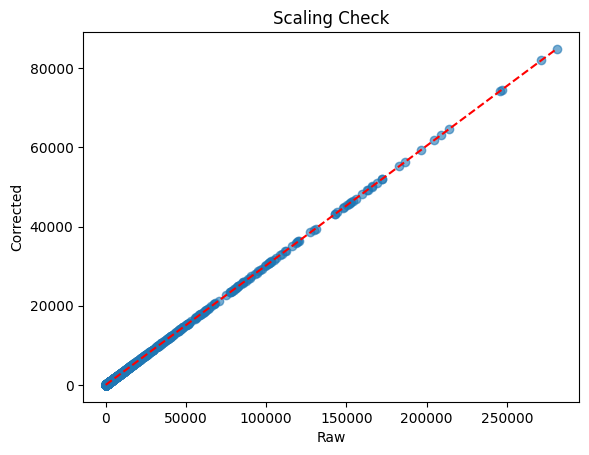


Exported!


In [7]:
# Point-in-polygon function (ray-casting)
def point_in_polygon(x, y, poly):
    n = len(poly)
    inside = False
    p1x, p1y = poly[0]
    for i in range(n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# Load Nairobi JSON (robust parsing)
nairobi_file = '/home/dataopske/Desktop/jav/data/raw/supportdata/nairobi.json'
try:
    with open(nairobi_file, 'r') as f:
        nairobi_data = json.load(f)
    
    # Auto-detect structure
    if 'features' in nairobi_data and nairobi_data['features']:
        feature = nairobi_data['features'][0]  # FeatureCollection
    else:
        feature = nairobi_data  # Single Feature or raw
    
    geom = feature['geometry']
    poly_type = geom['type']
    
    if poly_type == 'Polygon':
        poly_coords = geom['coordinates'][0]  # Exterior ring
    elif poly_type == 'MultiPolygon':
        poly_coords = geom['coordinates'][0][0]  # First polygon's exterior
    elif poly_type == 'GeometryCollection':
        # Fallback to first Polygon
        for child in geom['geometries']:
            if child['type'] == 'Polygon':
                poly_coords = child['coordinates'][0]
                break
        else:
            raise ValueError("No Polygon in GeometryCollection")
    else:
        raise ValueError(f"Unsupported geometry type: {poly_type}")
    
    poly = np.array(poly_coords)  # [lon, lat] assumed
    print(f"Loaded polygon: {poly_type} with {len(poly)} points")
    
except Exception as e:
    print(f"JSON error: {e}. Falling back to bounds mask.")
    # Fallback: Rough Nairobi box (lon 36.75-36.95, lat -1.4 to -1.2)
    poly = np.array([[36.75, -1.4], [36.95, -1.4], [36.95, -1.2], [36.75, -1.2], [36.75, -1.4]])  # Square approx

# Load raw data
pop_file = '/home/dataopske/Desktop/jav/data/raw/worldmove/grid-cell_population.npy'
population_raw = np.load(pop_file)
pop_flat_raw = population_raw.flatten()

# Generate centroids if missing
if 'lat' not in coord_df.columns or 'lon' not in coord_df.columns:
    rows, cols = population_raw.shape
    lat_min, lat_max, lon_min, lon_max = -1.47, -1.0, 36.65, 37.0
    lat_centers = np.linspace(lat_max - 0.0045, lat_min + 0.0045, rows)
    lon_centers = np.linspace(lon_min + 0.0045, lon_max - 0.0045, cols)
    lat_grid, lon_grid = np.meshgrid(lat_centers, lon_centers, indexing='ij')
    lats_1d, lons_1d = lat_grid.flatten(), lon_grid.flatten()
    coord_df = pd.DataFrame({'lat': lats_1d, 'lon': lons_1d})

# Compute inside_nairobi mask
inside_nairobi = [point_in_polygon(lon, lat, poly) for lon, lat in zip(coord_df['lon'], coord_df['lat'])]
coord_df['inside_nairobi'] = inside_nairobi
n_inside = coord_df['inside_nairobi'].sum()
print(f"Mask: {n_inside} / {len(coord_df)} cells inside")

# Step 1: Assign raw pop
coord_df['population_raw'] = pop_flat_raw[:len(coord_df)]

# Step 2: Calculate raw population INSIDE
raw_inside_nairobi = coord_df.loc[coord_df['inside_nairobi'], 'population_raw'].sum()

# Step 3: Known pop
known_nairobi_pop = 4_800_000

# Step 4: Factor
normalization_factor = raw_inside_nairobi / known_nairobi_pop

print(f"Raw inside: {raw_inside_nairobi:,.0f}")
print(f"Known: {known_nairobi_pop:,.0f}")
print(f"Factor: {normalization_factor:.4f}x")

# Step 5: Apply to entire
coord_df['population_corrected'] = coord_df['population_raw'] / normalization_factor

# Results
total_corrected = coord_df['population_corrected'].sum()
inside_corrected = coord_df.loc[coord_df['inside_nairobi'], 'population_corrected'].sum()
outside_corrected = total_corrected - inside_corrected

print(f"\n✓ Corrected:")
print(f"  Inside: {inside_corrected:,.0f}")
print(f"  Outside: {outside_corrected:,.0f}")
print(f"  Total: {total_corrected:,.0f}")

# Viz
plt.scatter(coord_df['population_raw'], coord_df['population_corrected'], alpha=0.6)
plt.plot([0, coord_df['population_raw'].max()], [0, coord_df['population_raw'].max() / normalization_factor], 'r--')
plt.xlabel('Raw'); plt.ylabel('Corrected')
plt.title('Scaling Check')
plt.savefig('scaling_viz.png')
plt.show()

coord_df.to_csv('coord_df_corrected.csv', index=False)
print("\nExported!")

In [8]:
coord_df

cell_id        lon       lat  inside_nairobi  population_raw  \
0           0  36.668782 -1.165734           False     4899.411133   
1           1  36.675437 -1.167976           False     2851.202393   
2           2  36.689270 -1.165173           False     1454.953857   
3           3  36.697704 -1.167777           False      683.373230   
4           4  36.709964 -1.161586           False      519.629150   
...       ...        ...       ...             ...             ...   
1435     1435  37.057568 -1.428876           False      152.713409   
1436     1436  37.062095 -1.428653           False       80.700966   
1437     1437  37.073072 -1.422124           False       59.092129   
1438     1438  37.083236 -1.423418           False       64.625671   
1439     1439  37.085200 -1.422310           False       91.998825   

      population_corrected  
0              1479.965753  
1               861.263075  
2               439.498099  
3               206.426640  
4               156.964445  
...                    ...  
1435             46.130159  
1436             24.377351  
1437             17.849967  
1438             19.521485  
1439             27.790097  

[1440 rows x 6 columns]

### Visualisation

In [9]:
import numpy as np
import geopandas as gpd
import folium
from shapely.geometry import Polygon, MultiPolygon, Point
from branca.colormap import LinearColormap
import pandas as pd  # For loading coord_df if needed
import warnings  # Optional: to suppress if you want

# Optional: Suppress the specific warning (use sparingly)
warnings.filterwarnings('ignore', message='Geometry is in a geographic CRS')

# Load Nairobi boundary (GeoJSON)
nairobi_boundary_file = '/home/dataopske/Desktop/jav/data/raw/supportdata/nairobi.json'
nairobi_gdf = gpd.read_file(nairobi_boundary_file)
# Ensure CRS is WGS84 (lat/lon)
nairobi_gdf = nairobi_gdf.to_crs(epsg=4326)
# Extract polygon geometry safely
geom = nairobi_gdf.geometry.iloc[0]
# Handle cases: GeometryCollection, MultiPolygon, or Polygon
if geom.geom_type == 'GeometryCollection':
    # Filter for the first polygon in the collection
    polygons = [g for g in geom.geoms if g.geom_type in ['Polygon', 'MultiPolygon']]
    if polygons:
        geom = polygons[0]
    else:
        raise ValueError("No polygon geometry found in the collection!")
if geom.geom_type == 'MultiPolygon':
    # Use the largest polygon by area (common for administrative boundaries)
    geom = max(geom.geoms, key=lambda g: g.area)
# Now safely extract coordinates
boundary_coords = np.array(geom.exterior.coords)
boundary_flipped = [[y, x] for x, y in boundary_coords]  # Folium expects [lat, lon]

# Load or assume coord_df with population data (from previous processing)
# Uncomment if not in memory:
# coord_df = pd.read_csv('coord_df_corrected.csv')
# Ensure required columns exist
required_cols = ['lat', 'lon', 'population_corrected', 'population_raw']
if not all(col in coord_df.columns for col in required_cols):
    raise ValueError(f"coord_df missing columns: {set(required_cols) - set(coord_df.columns)}")

# Compute dynamic inside mask using the loaded geom (vectorized for efficiency)
points_gdf = gpd.GeoDataFrame(
    coord_df, 
    geometry=gpd.points_from_xy(coord_df.lon, coord_df.lat), 
    crs='EPSG:4326'
)
inside_mask = points_gdf.within(geom)
coord_df['inside_nairobi_dynamic'] = inside_mask  # Add for reference

# FIXED: Compute map center from boundary centroid (project for accuracy)
# Project to UTM 37N (meters-based, accurate for Kenya)
nairobi_proj = nairobi_gdf.to_crs('EPSG:32637')
cent_proj = nairobi_proj.geometry.centroid.iloc[0]  # No warning here!
center_lon = cent_proj.x  # Easting in meters -> but wait, we need lon/lat
center_lat = cent_proj.y  # Northing in meters

# Transform back to 4326 for map-friendly degrees
nairobi_back = nairobi_proj.to_crs('EPSG:4326')
center_lon = nairobi_back.geometry.centroid.x.iloc[0]
center_lat = nairobi_back.geometry.centroid.y.iloc[0]
print(f"Accurate centroid: [{center_lat:.6f}, {center_lon:.6f}]")  # Extra precision shown

# === Plot on Folium ===
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="cartodbpositron")

# Add Nairobi boundary polygon
folium.Polygon(
    locations=boundary_flipped,
    color="blue",
    weight=2,
    fill=True,
    fill_opacity=0.15,
    popup="Nairobi Boundary"
).add_to(m)

# Create color map for corrected population
pop_max = coord_df['population_corrected'].max()
pop_colormap = LinearColormap(
    colors=['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026'],
    vmin=0,
    vmax=pop_max,
    caption='Corrected Population per Cell (~km²)'
)

# Group for population markers (corrected)
pop_group = folium.FeatureGroup(name='Corrected Population', show=True)

# Add population circles (only for cells with pop > 0)
for idx, row in coord_df.iterrows():
    if row['population_corrected'] > 0:
        # Radius scaled by sqrt for area representation; adjust 0.05 for visibility
        radius = np.sqrt(row['population_corrected']) * 0.05
        color = pop_colormap(row['population_corrected'])
        is_inside = row['inside_nairobi_dynamic']
        
        # Base popup content
        popup_html = f"<b>Cell {idx}</b><br>Corrected Pop: {row['population_corrected']:,.0f}<br>Raw Pop: {row['population_raw']:,.0f}<br>Density: ~{row['population_corrected']:,.0f} people/km²<br>Location: [{row['lat']:.4f}, {row['lon']:.4f}]"
        if is_inside:
            popup_html += "<br><b>Inside Nairobi</b>"
        else:
            popup_html += "<br><i>Outside Nairobi</i>"
        
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"Cell {idx}: {row['population_corrected']:,.0f} people (Inside: {is_inside})",
            color=color if is_inside else '#808080',  # Gray outline for outside
            fill=True,
            fillColor=color if is_inside else '#d3d3d3',  # Gray fill for outside
            fillOpacity=0.6 if is_inside else 0.3,
            weight=1
        ).add_to(pop_group)

pop_group.add_to(m)

# Add tile layers for variety
folium.TileLayer('OpenStreetMap', name='Default').add_to(m)
folium.TileLayer('cartodbdark_matter', name='Dark Map').add_to(m)

# Add legend and controls
pop_colormap.add_to(m)
folium.LayerControl().add_to(m)

# Display inline in Jupyter
m

Accurate centroid: [-1.298169, 36.859697]


### Wards in Nairobi

In [10]:
import zipfile

# Open the ZIP file in read mode ('r')
zip_path = '/home/dataopske/Desktop/jav/data/raw/kenyawards/kenya_wards.zip'  # Replace with your ZIP file path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()  # Returns a list of file paths (including subdirs)
    print(file_list)  # e.g., ['data.csv', 'folder/image.jpg']
    pass

['Kenya_Wards/', 'Kenya_Wards/kenya_wards.cpg', 'Kenya_Wards/kenya_wards.dbf', 'Kenya_Wards/kenya_wards.prj', 'Kenya_Wards/kenya_wards.qpj', 'Kenya_Wards/kenya_wards.shp', 'Kenya_Wards/kenya_wards.shx']


In [11]:
# Read the specific shapefile inside the zip
wards_gdf = gpd.read_file(f"zip://{zip_path}!Kenya_Wards/kenya_wards.shp")

# Show first few rows
wards_gdf.head()
# wards_gdf.crs

gid  pop2009  county          subcounty                    ward  \
0   241  17431.0  ISIOLO  Isiolo Sub County                  WABERA   
1  1455  18755.0  Migori   Rongo Sub County    North Kamagambo Ward   
2  1456  27756.0  Migori   Rongo Sub County  Central Kamagambo Ward   
3  1457  27179.0  Migori   Rongo Sub County    South Kamagambo Ward   
4  1458  22874.0  Migori  Awendo Sub County        North Sakwa Ward   

           uid        scuid         cuid  \
0  rIdiIpv9fBt  I2LYLqKU6AW  bzOfj0iwfDH   
1  QC41mItjIzF  fT37q3rXQ35  fVra3Pwta0Q   
2  M8rGveWTIMm  fT37q3rXQ35  fVra3Pwta0Q   
3  DABObbHgPMX  fT37q3rXQ35  fVra3Pwta0Q   
4  EmSsP2C6A3h  ka9Uv3Ckcbd  fVra3Pwta0Q   

                                            geometry  
0  POLYGON ((37.59968 0.40029, 37.59976 0.40004, ...  
1  POLYGON ((34.59938 -0.65054, 34.60006 -0.65069...  
2  POLYGON ((34.61175 -0.73357, 34.61183 -0.73357...  
3  POLYGON ((34.61751 -0.87293, 34.6175 -0.87294,...  
4  POLYGON ((34.55349 -0.75193, 34.55364 -0.75195...

In [12]:
wards_gdf.shape

(1450, 9)

In [13]:
wards_gdf.columns

Index(['gid', 'pop2009', 'county', 'subcounty', 'ward', 'uid', 'scuid', 'cuid',
       'geometry'],
      dtype='object')

In [14]:
wards_nbo =  wards_gdf.loc[wards_gdf['county'] == 'Nairobi']

In [15]:
wards_nbo

gid  pop2009   county                   subcounty  \
593   2044  55158.0  Nairobi         Ruaraka  Sub County   
596   2047  70641.0  Nairobi   Embakasi South Sub County   
920   2008  38384.0  Nairobi       Westlands  Sub County   
921   2012  43122.0  Nairobi  Dagoretti North Sub County   
922   2015  27202.0  Nairobi  Dagoretti North Sub County   
...    ...      ...      ...                         ...   
1243  2087  28260.0  Nairobi         Mathare  Sub County   
1244  2089  34523.0  Nairobi         Mathare  Sub County   
1245  2090  38374.0  Nairobi         Mathare  Sub County   
1246  2091  33824.0  Nairobi         Mathare  Sub County   
1247  2092  31242.0  Nairobi       Westlands  Sub County   

                          ward          uid        scuid         cuid  \
593         Mathare North Ward  dOQTHZsuaIb  Cc8uEFkzfVf  jkG3zaihdSs   
596           Imara Daima Ward  Nt7PPe0Vdou  aDp1odOWYC1  jkG3zaihdSs   
920   Parklands/highridge Ward  QhDd2LAuXAF  f1T0Ltob8VQ  jkG3zaihdSs   
921              Kilimani Ward  yXbOIljEz90  CcTr4bcVGAG  jkG3zaihdSs   
922            Kileleshwa Ward  DnVTXbCnup5  CcTr4bcVGAG  jkG3zaihdSs   
...                        ...          ...          ...          ...   
1243             Mabatini Ward  rD8Z7AgYLaS  gh2kzpOFCeF  jkG3zaihdSs   
1244                 Ngei Ward  tsmsPb6qMFa  gh2kzpOFCeF  jkG3zaihdSs   
1245              Mlango Kubwa  lvETWuhiIMi  gh2kzpOFCeF  jkG3zaihdSs   
1246             Kiamaiko Ward  tgAB60BL0u9  gh2kzpOFCeF  jkG3zaihdSs   
1247             Kitisuru Ward  TpTOC5VcUGe  f1T0Ltob8VQ  jkG3zaihdSs   

                                               geometry  
593   POLYGON ((36.87653 -1.2521, 36.87618 -1.25223,...  
596   POLYGON ((36.87934 -1.31037, 36.87934 -1.31037...  
920   POLYGON ((36.80712 -1.24986, 36.80714 -1.24988...  
921   POLYGON ((36.7825 -1.26623, 36.78235 -1.2667, ...  
922   POLYGON ((36.78027 -1.25888, 36.78131 -1.259, ...  
...                                                 ...  
1243  POLYGON ((36.86432 -1.25891, 36.86437 -1.25903...  
1244  POLYGON ((36.87267 -1.25406, 36.87279 -1.25434...  
1245  POLYGON ((36.84715 -1.2632, 36.84723 -1.2633, ...  
1246  POLYGON ((36.87861 -1.25146, 36.87862 -1.25186...  
1247  POLYGON ((36.76252 -1.23385, 36.76298 -1.23391...  

[85 rows x 9 columns]

In [16]:
import folium
import geopandas as gpd

# Your GeoDataFrame (already loaded)
zip_path = '/home/dataopske/Desktop/jav/data/raw/kenyawards/kenya_wards.zip'
wards_gdf = gpd.read_file(f"zip://{zip_path}!Kenya_Wards/kenya_wards.shp")

# Make sure it's in WGS84 (latitude/longitude) for Folium
wards_nbo = wards_nbo.to_crs(epsg=4326)

# Center the map (Kenya)
m = folium.Map(location=[0.1, 37.9], zoom_start=6, tiles='CartoDB positron')

# Add the wards GeoDataFrame
folium.GeoJson(
    wards_nbo,
    name='Nairobi Wards',
    style_function=lambda feature: {
        'fillColor': '#3186cc',
        'color': 'black',
        'weight': 0.4,
        'fillOpacity': 0.4,
    },
    tooltip=folium.features.GeoJsonTooltip(fields=['county', 'subcounty', 'ward'])
).add_to(m)

# Add layer controla
folium.LayerControl().add_to(m)

m

In [17]:
# convert our coord_df into a geodataframe
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lon/lat
coord_gdf = gpd.GeoDataFrame(
    coord_df,
    geometry=gpd.points_from_xy(coord_df['lon'], coord_df['lat']),
    crs='EPSG:4326'
)
coord_gdf = coord_gdf.loc[coord_gdf['inside_nairobi_dynamic'] == True]

In [18]:

wards_nbo = wards_nbo.to_crs(epsg=4326)

In [19]:
coord_with_wards = gpd.sjoin(
    coord_gdf,
    wards_nbo[['ward', 'subcounty', 'geometry']], 
    how='left',
    predicate='within'   # checks if point lies inside a ward polygon
)


In [20]:
coord_with_wards

cell_id        lon       lat  inside_nairobi  population_raw  \
26         26  36.902065 -1.164995           False     9894.172852   
28         28  36.917433 -1.167603           False     5419.624023   
73         73  36.897392 -1.171370           False    29171.931641   
74         74  36.900246 -1.172399           False    32064.423828   
75         75  36.914811 -1.177638           False    12840.165039   
...       ...        ...       ...             ...             ...   
1374     1374  36.938803 -1.414680           False      500.748138   
1420     1420  36.919903 -1.423611           False       40.296005   
1421     1421  36.924634 -1.426410           False       74.930229   
1422     1422  36.941555 -1.425514           False      235.823578   
1423     1423  36.948495 -1.423573           False      589.272461   

      population_corrected  inside_nairobi_dynamic                   geometry  \
26             2988.734070                    True  POINT (36.90206 -1.16499)   
28             1637.106528                    True   POINT (36.91743 -1.1676)   
73             8811.969155                    True  POINT (36.89739 -1.17137)   
74             9685.704643                    True   POINT (36.90025 -1.1724)   
75             3878.630310                    True  POINT (36.91481 -1.17764)   
...                    ...                     ...                        ...   
1374            151.261055                    True   POINT (36.9388 -1.41468)   
1420             12.172220                    True   POINT (36.9199 -1.42361)   
1421             22.634184                    True  POINT (36.92463 -1.42641)   
1422             71.235259                    True  POINT (36.94155 -1.42551)   
1423            178.001608                    True  POINT (36.94849 -1.42357)   

      index_right             ward             subcounty  
26         1197.0      Kahawa West  Roysambu  Sub County  
28         1197.0      Kahawa West  Roysambu  Sub County  
73         1197.0      Kahawa West  Roysambu  Sub County  
74         1197.0      Kahawa West  Roysambu  Sub County  
75         1197.0      Kahawa West  Roysambu  Sub County  
...           ...              ...                   ...  
1374       1170.0  Mugumo-ini Ward   Langata  Sub County  
1420       1170.0  Mugumo-ini Ward   Langata  Sub County  
1421       1170.0  Mugumo-ini Ward   Langata  Sub County  
1422       1170.0  Mugumo-ini Ward   Langata  Sub County  
1423          NaN              NaN                   NaN  

[738 rows x 11 columns]

In [21]:
ward_pop = (
    coord_with_wards
    .groupby('ward', as_index=False)['population_corrected']
    .sum()
    .rename(columns={'population_corrected': 'population'})
)

wards_nbo = wards_nbo.merge(ward_pop, on='ward', how='left')
wards_nbo['population'] = wards_nbo['population'].fillna(0)

In [22]:
wards_nbo

gid  pop2009   county                   subcounty  \
0   2044  55158.0  Nairobi         Ruaraka  Sub County   
1   2047  70641.0  Nairobi   Embakasi South Sub County   
2   2008  38384.0  Nairobi       Westlands  Sub County   
3   2012  43122.0  Nairobi  Dagoretti North Sub County   
4   2015  27202.0  Nairobi  Dagoretti North Sub County   
..   ...      ...      ...                         ...   
80  2087  28260.0  Nairobi         Mathare  Sub County   
81  2089  34523.0  Nairobi         Mathare  Sub County   
82  2090  38374.0  Nairobi         Mathare  Sub County   
83  2091  33824.0  Nairobi         Mathare  Sub County   
84  2092  31242.0  Nairobi       Westlands  Sub County   

                        ward          uid        scuid         cuid  \
0         Mathare North Ward  dOQTHZsuaIb  Cc8uEFkzfVf  jkG3zaihdSs   
1           Imara Daima Ward  Nt7PPe0Vdou  aDp1odOWYC1  jkG3zaihdSs   
2   Parklands/highridge Ward  QhDd2LAuXAF  f1T0Ltob8VQ  jkG3zaihdSs   
3              Kilimani Ward  yXbOIljEz90  CcTr4bcVGAG  jkG3zaihdSs   
4            Kileleshwa Ward  DnVTXbCnup5  CcTr4bcVGAG  jkG3zaihdSs   
..                       ...          ...          ...          ...   
80             Mabatini Ward  rD8Z7AgYLaS  gh2kzpOFCeF  jkG3zaihdSs   
81                 Ngei Ward  tsmsPb6qMFa  gh2kzpOFCeF  jkG3zaihdSs   
82              Mlango Kubwa  lvETWuhiIMi  gh2kzpOFCeF  jkG3zaihdSs   
83             Kiamaiko Ward  tgAB60BL0u9  gh2kzpOFCeF  jkG3zaihdSs   
84             Kitisuru Ward  TpTOC5VcUGe  f1T0Ltob8VQ  jkG3zaihdSs   

                                             geometry     population  
0   POLYGON ((36.87653 -1.2521, 36.87618 -1.25223,...   74177.992829  
1   POLYGON ((36.87934 -1.31037, 36.87934 -1.31037...   92557.211478  
2   POLYGON ((36.80712 -1.24986, 36.80714 -1.24988...   69612.843253  
3   POLYGON ((36.7825 -1.26623, 36.78235 -1.2667, ...  142658.597296  
4   POLYGON ((36.78027 -1.25888, 36.78131 -1.259, ...   81906.408407  
..                                                ...            ...  
80  POLYGON ((36.86432 -1.25891, 36.86437 -1.25903...   48278.476367  
81  POLYGON ((36.87267 -1.25406, 36.87279 -1.25434...       0.000000  
82  POLYGON ((36.84715 -1.2632, 36.84723 -1.2633, ...       0.000000  
83  POLYGON ((36.87861 -1.25146, 36.87862 -1.25186...   74514.220482  
84  POLYGON ((36.76252 -1.23385, 36.76298 -1.23391...  154593.609337  

[85 rows x 10 columns]

In [29]:
wards_nbo['population'].min()

np.float64(0.0)

In [24]:
import geopandas as gpd

# Convert to a projected CRS in meters (for accurate area calc)
wards_nbo = wards_nbo.to_crs(epsg=32737)  # UTM Zone 37S — covers Nairobi region well

# Compute area in km²
wards_nbo['area_km2'] = wards_nbo.geometry.area / 1_000_000

# Compute population density (people per km²)
wards_nbo['pop_density'] = wards_nbo['population'] / wards_nbo['area_km2']

# Convert back to WGS84 for Folium
wards_nbo = wards_nbo.to_crs(epsg=4326)


In [28]:
import folium
from branca.colormap import LinearColormap

colormap = LinearColormap(
    colors=['#fff5f0', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15'],
    vmin=wards_nbo['pop_density'].min(),
    vmax=wards_nbo['pop_density'].max(),
    caption='Population Density (people/km²)'
)


# Create map centered on Nairobi
m = folium.Map(location=[-1.29, 36.82], zoom_start=11, tiles='CartoDB positron')

# Add ward polygons colored by density
folium.GeoJson(
    wards_nbo,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['pop_density']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['ward', 'subcounty', 'population', 'area_km2', 'pop_density'],
        aliases=['Ward', 'Subcounty', 'Population', 'Area (km²)', 'Pop Density (/km²)'],
        localize=True
    ),
    name='Population Density'
).add_to(m)

# Add color legend
colormap.add_to(m)

# Add control
folium.LayerControl().add_to(m)

m


In [30]:
import folium
from branca.colormap import LinearColormap
import matplotlib.cm as cm
import matplotlib.colors as colors

# Choose a Matplotlib colormap ('viridis', 'inferno', 'plasma', 'magma', etc.)
cmap = cm.get_cmap('inferno', 256)  # change to 'viridis' if you prefer cooler tones

# Convert Matplotlib colormap to list of hex colors
color_list = [colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

# Create a Folium LinearColormap
colormap = LinearColormap(
    colors=color_list,
    vmin=wards_nbo['pop_density'].min(),
    vmax=wards_nbo['pop_density'].max(),
    caption='Population Density (people/km²)'
)

# Create Folium map centered on Nairobi
m = folium.Map(location=[-1.29, 36.82], zoom_start=11, tiles='CartoDB positron')

# Add ward polygons colored by population density
folium.GeoJson(
    wards_nbo,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['pop_density']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.8
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['ward', 'subcounty', 'population', 'area_km2', 'pop_density'],
        aliases=['Ward', 'Subcounty', 'Population', 'Area (km²)', 'Density (/km²)'],
        localize=True
    )
).add_to(m)

colormap.add_to(m)
m


/tmp/ipykernel_570638/663782337.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('inferno', 256)  # change to 'viridis' if you prefer cooler tones


In [31]:
import plotly.express as px

fig = px.choropleth(
    wards_nbo,
    geojson=wards_nbo.geometry,
    locations=wards_nbo.index,
    color="pop_density",
    color_continuous_scale="Inferno"
)
fig.update_geos(fitbounds="locations", visible=False)
fig.write_image("nairobi_density.png")  # Save static image


ModuleNotFoundError: No module named 'plotly'